# Matching Phase Utilizando o GA
Casamento de fase aplicando o Simulador e o GA.

## Bibliotecas

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 12.2 MB/s eta 0:00:00


In [ ]:
# -*- coding: utf-8 -*-
"""MP_GA.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1o5Lm2ZmsVpVzeS9QBO0Q_F6OPLlirt26

# Matching Phase Utilizando o GA
Casamento de fase aplicando o Simulador e o GA.

## Bibliotecas
"""


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from deap import base, creator, tools, algorithms

"""## Estruturas para utilizar o Simulador e o Gerador"""

class ResBlock(nn.Module):
    """
    Define um bloco ResNet bÃ¡sico
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.main_path = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut_path = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(

                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.main_path(x) + self.shortcut_path(x)
        out = F.relu(out)
        return out

# N_OUTPUTS Ã© quantos valores se quer prever
N_OUTPUTS = 4

class ResNetSimulator(nn.Module):
    """
    ImplementaÃ§Ã£o do Simulator baseado em ResNet.
    """
    def __init__(self, in_channels=1, n_outputs=N_OUTPUTS):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = ResBlock(64, 64, stride=1)

        self.layer2 = ResBlock(64, 128, stride=2)

        self.layer3 = ResBlock(128, 256, stride=2)

        self.layer4 = ResBlock(256, 256, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        self.head = nn.Sequential(
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.head(out)
        return out

class Sin(nn.Module):
    def forward(self, x): return torch.sin(x)

class Gaussian(nn.Module):
    def forward(self, x): return torch.exp(-x**2)

def make_coordinate_grid(size, device='cpu'):
    """Cria grade de coordenadas (x, y)"""
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(xs, ys)

    coords = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype(np.float32)
    return torch.from_numpy(coords).to(device) # shape (size*size, 2)

class CPPN_Generator(nn.Module):
    """
    Gerador CPPN. Mapeia (vetor latente 'v' + coords 'x,y,r') -> pixel.
    """
    def __init__(self, latent_dim, in_coords=2, out_channels=1, hidden_dim=64):
            super().__init__()
            self.latent_dim = latent_dim
            self.in_coords = in_coords
            self.out_channels = out_channels

            input_dim = in_coords + latent_dim

            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(0.2),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, out_channels),
                nn.Sigmoid()
            )

    def forward(self, coords, v):

        v_expanded = v.unsqueeze(1)
        v_tiled = v_expanded.repeat(1, coords.size(0), 1)

        coords_tiled = coords.unsqueeze(0).repeat(v.size(0), 1, 1)

        combined_input = torch.cat([coords_tiled, v_tiled], dim=-1)

        output = self.net(combined_input)

        img_size = int(np.sqrt(coords.size(0)))

        output = output.permute(0, 2, 1).view(-1, self.out_channels, img_size, img_size)

        return output

"""# Mapas de Fase

CriaÃ§Ã£o do mapa de fase para a polarizaÃ§Ã£o x:
"""

def load_and_preprocess_image(image_path, target_size=(450, 450)):
    """
    Carrega e prÃ©-processa a imagem alvo usando PIL
    """
    try:
        image = Image.open(image_path).convert('L')
        image = image.resize(target_size, Image.LANCZOS)
        image_array = np.array(image, dtype=np.float64)
        image_array = image_array / np.max(image_array)
        return image_array
    except FileNotFoundError:
        print(f"AtenÃ§Ã£o: Imagem '{image_path}' nÃ£o encontrada. Criando imagem de teste...")
        target_image = np.zeros(target_size)
        target_image[150:300, 100:200] = 1.0
        target_image[150:200, 200:350] = 1.0
        target_image[250:300, 200:350] = 1.0
        return target_image

def apply_zero_padding(image, padding_factor=2):
    """
    Aplica zero-padding Ã  imagem
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)

    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0],
                 start_col:start_col+original_size[1]] = image

    return padded_image, original_size

def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    Cria filtro passa-baixa baseado na abertura numÃ©rica
    """
    nx, ny = shape
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    f_cutoff = NA / wavelength
    freq_radius = np.sqrt(FX**2 + FY**2)
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)

    return filter_mask

def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    Propaga o campo usando mÃ©todo do espectro angular
    """
    k = 2 * np.pi / wavelength
    nx, ny = U.shape

    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    root_term[root_term < 0] = 0

    H = np.exp(1j * k * z * np.sqrt(root_term))

    if filter_mask is not None:
        H = H * filter_mask

    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)

    return U_prop

def calculate_correlation(target, reconstructed):
    """
    Calcula a correlaÃ§Ã£o de Pearson entre duas imagens (valores reais)
    """
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()

    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]

    if np.isnan(correlation):
        return 0.0

    return float(correlation)

def extract_center(image, original_size):
    """
    Extrai regiÃ£o central da imagem (remove padding)
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]

def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    ReconstrÃ³i a imagem a partir do mapa de fase
    """
    # Aplica zero-padding ao mapa de fase
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))

    # Cria filtro
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)

    # Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)

    # Extrai regiÃ£o central e pega a amplitude (np.abs)
    reconstructed = extract_center(np.abs(reconstructed), original_size)

    return np.real(reconstructed)  # Garante valor real

def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    Algoritmo de Gerchberg-Saxton com espectro angular
    Retornar a imagem original e a reconstruÃ­da
    """
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape

    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)

    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)

    correlations = []

    for i in range(num_iter):
        # 1. Propaga para o plano da imagem
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)

        # 2. MantÃ©m a fase, atualiza amplitude com alvo
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)

        # Calcula correlaÃ§Ã£o para monitorar convergÃªncia
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)

        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)

        # Atualiza campo no plano da imagem
        U_image_updated = target_padded * np.exp(1j * phase_image)

        # 3. Propaga de volta para o plano do holograma
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)

        # 4. MantÃ©m a fase, atualiza amplitude com incidente (unitÃ¡ria)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram) # Amplitude unitÃ¡ria (holograma de fase)

        if (i + 1) % 10 == 0:
            print(f" 	IteraÃ§Ã£o GS (X) {i+1}/{num_iter}, CorrelaÃ§Ã£o: {corr:.4f}")

    phase_final = extract_center(np.angle(U), original_size)

    reconstructed_image = reconstruct_image(phase_final, wavelength, z, dx, NA)

    return target, reconstructed_image, phase_final, correlations

wavelength = 1064e-9  # 1064 nm
z = 380e-6           # 380 Î¼m
dx = 520e-9          # pixel pitch
NA = 0.65            # abertura numÃ©rica
num_iter = 200       # nÃºmero de iteraÃ§Ãµes

print("Carregando e prÃ©-processando imagem...")
target_original = load_and_preprocess_image('/content/WhatsApp Image 2025-11-06 at 16.18.47.png', target_size=(450, 450))

print("Executando algoritmo de Gerchberg-Saxton...")

img_original, img_reconstruida, mapa_de_fase, correlations = gerchberg_saxton_angular_spectrum(
    target_original,
    wavelength,
    z,
    dx,
    NA,
    num_iter
)
print(f"\nCorrelaÃ§Ã£o final: {correlations[-1]:.4f}")

print(f"DimensÃµes da Imagem Original: {img_original.shape}")
print(f"DimensÃµes da Imagem ReconstruÃ­da: {img_reconstruida.shape}")
print(f"DimensÃµes do Mapa de Fase: {mapa_de_fase.shape}")

# np.savetxt('phase_map_x_polarization.txt', mapa_de_fase)
# np.savetxt('correlations.txt', correlations)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 3, 2)
plt.imshow(mapa_de_fase, cmap='hsv')
plt.title('Mapa de Fase')

plt.subplot(2, 3, 3)
plt.imshow(img_reconstruida, cmap='gray')
plt.title('Imagem ReconstruÃ­da')

plt.subplot(2, 3, 5)
plt.plot(correlations)
plt.title('ConvergÃªncia')
plt.xlabel('IteraÃ§Ã£o')
plt.ylabel('CorrelaÃ§Ã£o')

plt.tight_layout()
#plt.show()

"""## PolarizaÃ§Ã£o y:"""

def generate_dammann_phase_map(
    P: float = 520e-9,
    wavelength: float = 1064e-9,
    supercell_pixels: int = 45,
    n_supercells: int = 10,
    iters_gs: int = 400,
    random_seed: int = 0,
    verbose: bool = True
) -> tuple[np.ndarray, dict, list]:
    """
    Gera o mapa de fase para uma grade de Dammann (spot-cloud) usando o algoritmo GS.
    """
    np.random.seed(random_seed)

    N_super = supercell_pixels
    dx = P
    d = dx * N_super

    # --- Grade k e alvo ---
    # (Esta funÃ§Ã£o usa np.fft, o que nÃ£o conflita com o Bloco 1)
    kx = np.fft.fftfreq(N_super, d=dx)
    ky = np.fft.fftfreq(N_super, d=dx)
    kx_shift = np.fft.fftshift(kx)
    ky_shift = np.fft.fftshift(ky)
    KX, KY = np.meshgrid(kx_shift, ky_shift)
    K_rad = np.sqrt(KX**2 + KY**2)
    target_radius = min(1.0 / wavelength, 1.0 / (2.0 * dx))
    target_amp = (K_rad <= target_radius).astype(float)

    # --- Algoritmo GS ---
    plane_field = np.exp(1j * 2.0 * np.pi * np.random.rand(N_super, N_super))
    errors = []

    # Loop de iteraÃ§Ã£o para Dammann
    gs_iterator = range(iters_gs)
    if verbose:
        # Cria uma barra de progresso se 'verbose' for True
        gs_iterator = tqdm(range(iters_gs), desc="  IteraÃ§Ãµes GS (Y)", leave=False)

    for it in gs_iterator:
        far = np.fft.fft2(plane_field)
        far_shift = np.fft.fftshift(far)

        amp_current = np.abs(far_shift)
        err = np.sqrt(np.mean((amp_current / (amp_current.max() + 1e-9) - target_amp)**2))
        errors.append(err)

        far_shift = target_amp * np.exp(1j * np.angle(far_shift))
        far = np.fft.ifftshift(far_shift)

        plane_field = np.fft.ifft2(far)
        plane_field = np.exp(1j * np.angle(plane_field))

    supercell_phase = np.angle(plane_field)

    # --- ConstruÃ§Ã£o da MetassuperfÃ­cie Completa ---
    full_phase = np.tile(supercell_phase, (n_supercells, n_supercells))

    if verbose:
        print(f"  Mapa Dammann (Y) gerado: {full_phase.shape} pixels")

    metrics = {} # Vazio, focado apenas na geraÃ§Ã£o de fase

    return full_phase, metrics, errors

def analyze_and_plot_results(
    full_phase: np.ndarray,
    errors: list,
    P: float,
    wavelength: float,
    supercell_pixels: int
) -> pd.DataFrame:
    """
    Analisa e plota os resultados da metassuperfÃ­cie.
    Retorna um DataFrame com os dados das ordens propagantes.
    """

    print("Iniciando anÃ¡lise e plotagem...")

    # --- Plot 1: Mapa de Fase ---
    print("Plot 1: Gerando plot_mapa_fase.png...")
    plt.figure(figsize=(7, 6))
    plt.imshow(full_phase, cmap='twilight', extent=None)
    plt.colorbar(label="Fase (rad)")
    plt.title(f"Mapa de Fase ({full_phase.shape[0]}x{full_phase.shape[1]} pixels)")
    plt.xlabel("Pixels (X)")
    plt.ylabel("Pixels (Y)")
    plt.tight_layout()
    plt.savefig("plot_mapa_fase.png", dpi=150)

    # --- Plot 2: EvoluÃ§Ã£o do Erro ---
    print("Plot 2: Gerando plot_erro_gs.png...")
    plt.figure(figsize=(7, 5))
    plt.plot(errors)
    plt.xlabel("IteraÃ§Ã£o GS")
    plt.ylabel("Erro RMSE")
    plt.title("EvoluÃ§Ã£o do Erro GS")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plot_erro_gs.png", dpi=150)

    # --- AnÃ¡lise de Far-Field (CÃ©lulas 8 & 9) ---
    print("AnÃ¡lise: Calculando Far-Field da metassuperfÃ­cie completa...")
    N_full = full_phase.shape[0]
    dx_full = P

    # Criar a grade k
    kx_full = np.fft.fftfreq(N_full, d=dx_full)
    ky_full = np.fft.fftfreq(N_full, d=dx_full)
    kx_full_shift = np.fft.fftshift(kx_full)
    ky_full_shift = np.fft.fftshift(ky_full)

    # Calcular o far-field
    plane_field_full = np.exp(1j * full_phase)
    far_field_full = np.fft.fft2(plane_field_full)
    far_field_full_shift = np.fft.fftshift(far_field_full)
    far_field_intensity = np.abs(far_field_full_shift)**2

    print("AnÃ¡lise: Extraindo ordens de difraÃ§Ã£o...")
    d_supercell = supercell_pixels * P
    max_order = int(np.floor((d_supercell) / wavelength))

    p_range = np.arange(-max_order, max_order + 1)
    q_range = np.arange(-max_order, max_order + 1)
    order_data = []

    for p in p_range:
        for q in q_range:
            k_p = p / d_supercell
            k_q = q / d_supercell

            idx_p = np.argmin(np.abs(kx_full_shift - k_p))
            idx_q = np.argmin(np.abs(ky_full_shift - k_q))

            k_rad_order = np.sqrt(k_p**2 + k_q**2)
            if k_rad_order <= (1.0 / wavelength):
                intensity = far_field_intensity[idx_q, idx_p]
                order_data.append({'p': p, 'q': q, 'intensity': intensity, 'k_p': k_p, 'k_q': k_q})

    df_orders = pd.DataFrame(order_data)
    print(f"AnÃ¡lise concluÃ­da. Encontradas {len(df_orders)} ordens propagantes.")

    print("Plot 3: Gerando plot_far_field.png...")
    log_intensity = np.log10(far_field_intensity + 1e-9)
    vmax_val = log_intensity.max()
    vmin_val = vmax_val - 4

    plt.figure(figsize=(7, 6))
    plt.imshow(
        log_intensity,
        cmap='hot',
        extent=[kx_full_shift.min(), kx_full_shift.max(), ky_full_shift.min(), ky_full_shift.max()],
        vmin=vmin_val,
        vmax=vmax_val,
        origin='lower'
    )

    k_max_plot = 1.0 / wavelength
    circle = plt.Circle((0, 0), k_max_plot, color='cyan', fill=False, linestyle='--', linewidth=1.5, label=r'$1/\lambda$')
    plt.gca().add_artist(circle)
    plt.legend(handles=[circle])

    plt.xlim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.ylim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.colorbar(label="Intensidade (log10)")
    plt.title("Far-Field (Intensidade LogarÃ­tmica)")
    plt.xlabel(r"$k_x$ (1/m)")
    plt.ylabel(r"$k_y$ (1/m)")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.savefig("plot_far_field.png", dpi=150)

    print("Plot 4: Gerando plot_ordens_scatter.png...")
    if not df_orders.empty:
        plt.figure(figsize=(7, 6))
        norm_intensity = df_orders['intensity'] / (df_orders['intensity'].max() + 1e-9)

        sc = plt.scatter(df_orders['p'], df_orders['q'], c=norm_intensity, cmap='viridis', s=50, edgecolor="k", vmin=0)
        plt.colorbar(sc, label="Intensidade Normalizada")
        plt.xlabel("Ordem p")
        plt.ylabel("Ordem q")
        plt.title(f"Mapa das Ordens Propagantes ({len(df_orders)} ordens)")
        plt.grid(True)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        plt.savefig("plot_ordens_scatter.png", dpi=150)
    else:
        print("Plot 4: DataFrame de ordens vazio, pulando o scatter plot.")

    print("\nTodos os plots foram salvos como arquivos .png.")

    return df_orders

P = 520e-9
wavelength = 1064e-9
supercell_pixels = 45
n_supercells = 10
iters_gs = 400
random_seed = 0

print("Iniciando GeraÃ§Ã£o de Fase...")
full_phase, _, errors = generate_dammann_phase_map(
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels,
    n_supercells=n_supercells,
    iters_gs=iters_gs,
    random_seed=random_seed,
    verbose=True
)
print("GeraÃ§Ã£o de Fase ConcluÃ­da.")

df_ordens_propagantes = analyze_and_plot_results(
    full_phase=full_phase,
    errors=errors,
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels
)

print("\n--- Resumo das Ordens ---")
print(df_ordens_propagantes.head())

"""# Carregamento dos Modelos Treinados"""

IMG_SIZE = 64
LATENT_DIM = 128 # DimensÃ£o do vetor latente

GENERATOR_PATH = "/content/generator_teste_5_final.pth"
SIMULATOR_PATH = "/content/simulador_NG_teste_1.pth"

# --- Componentes Globais ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar Gerador
try:
    generator = CPPN_Generator(latent_dim=LATENT_DIM, in_coords=2).to(device)
    generator.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator.eval()
    print(f"Gerador '{GENERATOR_PATH}' carregado em {device}.")
except Exception as e:
    print(f"Erro ao carregar Gerador: {e}")
    exit()

# Carregar Simulador
try:
    # Use a arquitetura ResNet que vocÃª definiu (ex: ResNet-18)
    simulator = ResNetSimulator(in_channels=1, n_outputs=4).to(device)
    simulator.load_state_dict(torch.load(SIMULATOR_PATH, map_location=device))
    simulator.eval()
    print(f"Simulador '{SIMULATOR_PATH}' carregado em {device}.")
except Exception as e:
    print(f"Erro ao carregar Simulador: {e}")
    exit()

# Criar a grade de coordenadas (apenas uma vez)
def make_coordinate_grid(size, dev):
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(xs, ys)
    coords = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype(np.float32)
    return torch.from_numpy(coords).to(dev)

coords_grid = make_coordinate_grid(IMG_SIZE, device)
print("Grade de coordenadas criada.")

"""# Algoritmo GenÃ©tico"""

# MINIMIZAR o custo (-1.0)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Gene: um float aleatÃ³rio entre -1 e 1 (range comum para vetores latentes)
toolbox.register("attr_float", random.uniform, -1, 1)

# IndivÃ­duo: um vetor de LATENT_DIM (128) genes
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=LATENT_DIM)

# PopulaÃ§Ã£o: uma lista de indivÃ­duos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operadores genÃ©ticos
toolbox.register("mate", tools.cxBlend, alpha=0.5) # Cruzamento
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1) # MutaÃ§Ã£o
toolbox.register("select", tools.selTournament, tournsize=3) # SeleÃ§Ã£o

"""Loop principal:"""

# Carregar os mapas de fase alvo
phase_map_x = mapa_de_fase
phase_map_y = full_phase
rows, cols = phase_map_x.shape

# Armazenar os melhores vetores latentes encontrados
best_latent_vectors = np.empty((rows, cols), dtype=object)

# Parâmetros do GA (AGORA PODEM SER MAIORES)
POP_SIZE = 100   # Tamanho da população
NGEN = 50        # Número de gerações
CXPB = 0.7       # Probabilidade de crossover
MUTPB = 0.2      # Probabilidade de mutação

# Hall of Fame para guardar o melhor indivíduo de cada pixel
hof = tools.HallOfFame(1)

# Estatísticas (opcional)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

print(f"\n--- INICIANDO OTIMIZAÇÃO GA ({rows}x{cols} META-ÁTOMOS) ---")
print(f"População por átomo: {POP_SIZE}, Gerações por átomo: {NGEN}\n")

# --- Variáveis para Métricas ---
start_time = time.time()
total_nfe = 0
all_best_fitness = []
all_initial_avg_fitness = []
# --- Fim das Variáveis ---

# TQDM para o loop externo (total de pixels)
total_pixels = rows * cols
pixel_bar = tqdm(total=total_pixels, desc="Otimizando Meta-Átomos")

# Loop "Round-Robin" por cada meta-átomo
for i in range(rows):
    for j in range(cols):
        # O print(f"--- Otimizando meta-átomo [{i}, {j}] ---") foi removido
        # para não poluir a barra de progresso.

        # Obter os alvos de fase para este pixel
        target_px = phase_map_x[i, j]
        target_py = phase_map_y[i, j]

        # --- Início da Função de Fitness Vetorizada ---
        # (Definida aqui para capturar 'target_px' e 'target_py')
        def evaluate_population_batch(individuals, target_phase_x=target_px, target_phase_y=target_py):
            global generator, simulator, device, coords_grid
            try:
                pop_list = [list(ind) for ind in individuals]
                z_batch = torch.tensor(pop_list, dtype=torch.float32).to(device)
            except Exception as e:
                return [(1e9,)] * len(individuals)

            with torch.no_grad():
                imgs = generator(coords_grid, z_batch)
                imgs_binary = (imgs > 0.5).float()
                outputs_raw = simulator(imgs_binary)

                s24_r = outputs_raw[:, 0]
                s24_i = outputs_raw[:, 1]
                s13_r = outputs_raw[:, 2]
                s13_i = outputs_raw[:, 3]

                e_target_x_r = 1.0 * torch.cos(torch.tensor(target_phase_x, device=device))
                e_target_x_i = 1.0 * torch.sin(torch.tensor(target_phase_x, device=device))
                e_target_y_r = 1.0 * torch.cos(torch.tensor(target_phase_y, device=device))
                e_target_y_i = 1.0 * torch.sin(torch.tensor(target_phase_y, device=device))

                cost_x = torch.sqrt( (s13_r - e_target_x_r)**2 + (s13_i - e_target_x_i)**2 )
                cost_y = torch.sqrt( (s24_r - e_target_y_r)**2 + (s24_i - e_target_y_i)**2 )
                total_cost = cost_x + cost_y

                final_costs_cpu = total_cost.cpu().numpy()
                return [(cost,) for cost in final_costs_cpu]
        # --- Fim da Função de Fitness Vetorizada ---

        # --- Rastreamento de NFE ---
        nfe_this_pixel = 0 # Reset para este pixel

        # Criar a população inicial para este átomo
        pop = toolbox.population(n=POP_SIZE)
        hof.clear() # Limpar o hall of fame para este átomo

        # 1. Avaliar a população inicial inteira (EM LOTE)
        fitnesses = evaluate_population_batch(pop)
        nfe_this_pixel += len(pop) # <-- Rastreia NFE

        # Salvar média inicial para métrica de convergência
        current_fitnesses = [f[0] for f in fitnesses]
        all_initial_avg_fitness.append(np.mean(current_fitnesses))

        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        hof.update(pop)

        # Loop de Geração (Manual)
        for g in range(NGEN):
            # 1. Seleção
            offspring = toolbox.select(pop, len(pop))
            offspring = list(map(toolbox.clone, offspring)) # Clones

            # 2. Crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < CXPB:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # 3. Mutação
            for mutant in offspring:
                if random.random() < MUTPB:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values

            # 4. Avaliar *apenas* os inválidos (EM LOTE)
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            if invalid_ind:
                fitnesses = evaluate_population_batch(invalid_ind)
                nfe_this_pixel += len(invalid_ind) # <-- Rastreia NFE
                for ind, fit in zip(invalid_ind, fitnesses):
                    ind.fitness.values = fit

            # 5. Nova Geração
            pop[:] = offspring
            hof.update(pop)

            # O log de geração (print) foi removido para não poluir a TQDM

        # Salvar o melhor indivíduo (vetor latente) encontrado
        best_ind = hof[0]
        best_latent_vectors[i, j] = np.array(best_ind)

        # --- Rastreamento de Métricas ---
        all_best_fitness.append(best_ind.fitness.values[0])
        total_nfe += nfe_this_pixel
        # --- Fim do Rastreamento ---

        # Atualiza a barra de progresso
        pixel_bar.update(1)
        pixel_bar.set_postfix(last_fitness=f"{best_ind.fitness.values[0]:.4f}")

# Fim do loop principal
pixel_bar.close()
end_time = time.time() # Marcar o tempo final

print("\n--- OTIMIZAÇÃO CONCLUÍDA ---")
np.save("metasurface_latent_vectors.npy", best_latent_vectors)
print("Array de vetores latentes salvo em 'metasurface_latent_vectors.npy'")

"""# Cálculo e Salvamento de Métricas"""

print("\nCalculando métricas finais da otimização...")

total_execution_time = end_time - start_time
num_pixels = rows * cols

# Converter para numpy array para estatísticas fáceis
fitness_array = np.array(all_best_fitness)

# 1. Melhor Valor (Best Fitness) / Erro Médio
# A fitness JÁ é o erro, então a média é o Erro Médio.
mean_error = np.mean(fitness_array)
min_best_fitness = np.min(fitness_array) # O melhor pixel individual

# 2. Desvio Padrão (Standard Deviation)
std_dev_fitness = np.std(fitness_array)

# 3. Taxa de Sucesso (Success Rate)
# Definimos "sucesso" como um fitness/erro abaixo de um limiar.
SUCCESS_THRESHOLD = 0.1 # <-- Você pode ajustar este valor
successful_pixels = np.sum(fitness_array < SUCCESS_THRESHOLD)
success_rate = (successful_pixels / num_pixels) * 100

# 4. Convergência (Convergence Rate)
# Comparamos a média do erro inicial (Gen 0) com o erro final.
avg_initial_fitness = np.mean(all_initial_avg_fitness)
avg_final_fitness = mean_error
convergence_improvement = (avg_initial_fitness - avg_final_fitness)

# 5. Tempo de Execução e NFE (já calculados)
# total_execution_time
# total_nfe

# --- Criar o arquivo .txt ---
metrics_filename = "optimization_metrics.txt"
try:
    with open(metrics_filename, "w", encoding="utf-8") as f:
        f.write("--- Métricas da Otimização GA da Metassuperfície ---\n\n")
        f.write(f"Parâmetros do GA:\n")
        f.write(f"  Tamanho da População (por pixel): {POP_SIZE}\n")
        f.write(f"  Número de Gerações (por pixel): {NGEN}\n")
        f.write(f"  Total de Meta-Átomos Otimizados: {num_pixels} ({rows}x{cols})\n\n")

        f.write("--- Performance Computacional ---\n")
        f.write(f"Tempo de Execução Total: {total_execution_time:.2f} segundos\n")
        f.write(f"Número Total de Avaliações (NFE): {total_nfe}\n")
        f.write(f"NFE por pixel (média): {total_nfe / num_pixels:.1f}\n\n")

        f.write("--- Qualidade da Otimização (Fitness/Erro) ---\n")
        f.write(f"Erro Médio Final (Média do Best Fitness): {mean_error:.6f}\n")
        f.write(f"Melhor Fitness Individual (pixel único): {min_best_fitness:.6f}\n")
        f.write(f"Desvio Padrão (Fitness): {std_dev_fitness:.6f}\n\n")

        f.write("--- Métricas de Convergência ---\n")
        f.write(f"Erro Médio Inicial (Média da Pop. Gen 0): {avg_initial_fitness:.6f}\n")
        f.write(f"Melhoria Média (Inicial - Final): {convergence_improvement:.6f}\n")
        f.write(f"Taxa de Sucesso (Erro < {SUCCESS_THRESHOLD}): {success_rate:.2f} %\n")

    print(f"Métricas salvas com sucesso em '{metrics_filename}'")

except Exception as e:
    print(f"Erro ao salvar arquivo de métricas: {e}")

"""# VerificaÃ§Ã£o de Performance"""

print("\nVerificando performance final da metassuperfÃ­cie otimizada...")

final_phase_x = np.zeros((rows, cols))
final_phase_y = np.zeros((rows, cols))
final_amp_x = np.zeros((rows, cols))
final_amp_y = np.zeros((rows, cols))

for i in range(rows):
    for j in range(cols):

        z_vector = best_latent_vectors[i, j]

        z = torch.from_numpy(z_vector).float().unsqueeze(0).to(device)
        with torch.no_grad():
            img = generator(coords_grid, z)
            img_binary = (img > 0.5).float()
            outputs_raw = simulator(img_binary)

            s_tm = outputs_raw[0, 0].item() + 1j * outputs_raw[0, 1].item()
            s_te = outputs_raw[0, 2].item() + 1j * outputs_raw[0, 3].item()

        final_phase_x[i, j] = np.angle(s_te)
        final_amp_x[i, j] = np.abs(s_te)
        final_phase_y[i, j] = np.angle(s_tm)
        final_amp_y[i, j] = np.abs(s_tm)

# --- Plotar resultados ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.suptitle("Resultados Finais da OtimizaÃ§Ã£o", fontsize=16)

# Coluna 1: Alvos
im0 = axes[0, 0].imshow(phase_map_x, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 0].set_title("Alvo - Fase X (rad)")
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[1, 0].imshow(phase_map_y, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title("Alvo - Fase Y (rad)")
fig.colorbar(im1, ax=axes[1, 0])

# Coluna 2: Fases Obtidas
im2 = axes[0, 1].imshow(final_phase_x, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 1].set_title("Obtido - Fase X (rad)")
fig.colorbar(im2, ax=axes[0, 1])

im3 = axes[1, 1].imshow(final_phase_y, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[1, 1].set_title("Obtido - Fase Y (rad)")
fig.colorbar(im3, ax=axes[1, 1])

# Coluna 3: Amplitudes Obtidas
im4 = axes[0, 2].imshow(final_amp_x, cmap='viridis', vmin=0, vmax=1)
axes[0, 2].set_title("Obtido - Amplitude X (EficiÃªncia)")
fig.colorbar(im4, ax=axes[0, 2])

im5 = axes[1, 2].imshow(final_amp_y, cmap='viridis', vmin=0, vmax=1)
axes[1, 2].set_title("Obtido - Amplitude Y (EficiÃªncia)")
fig.colorbar(im5, ax=axes[1, 2])

plt.tight_layout()

plt.savefig("Resultados_Otimizacao_GA_Teste_1_09_11_25..png", dpi=300, bbox_inches="tight")

#plt.show()

print("\n--- Gerando Imagem da Metassuperfície Completa ---")
print("Isso pode demorar alguns minutos e consumir bastante RAM...")

try:
    # (Certifique-se que 'latent_vectors_array' foi carregado da célula anterior)
    rows, cols = best_latent_vectors.shape[0], best_latent_vectors.shape[1]

    # O tamanho da imagem de cada meta-átomo (ex: 64)
    img_size = IMG_SIZE

    # Lista para guardar as "tiras" de imagem (linhas completas)
    full_surface_rows_list = []

    # Iterar por *linha* de meta-átomos
    for i in tqdm(range(rows), desc="Gerando Linhas da Metassuperfície"):

        # 1. Pegar todos os vetores latentes desta linha (ex: 450 vetores)
        z_row_list = [best_latent_vectors[i, j] for j in range(cols)]
        z_row_tensor = torch.from_numpy(np.array(z_row_list)).float().to(device)
        # Shape: (450, 128)

        # 2. Gerar TODAS as 450 imagens da linha de uma vez (em batch)
        with torch.no_grad():
            # Gera (450, 1, 64, 64)
            img_row_batch = generator(coords_grid, z_row_tensor)
            img_row_binary = (img_row_batch > 0.5).float()

        # 3. "Costurar" as imagens horizontalmente
        # (450, 1, 64, 64) -> (64, 450*64)

        # Remove canal (450, 64, 64)
        img_row_binary = img_row_binary.squeeze(1)
        # Transpõe (64, 450, 64)
        img_row_binary = img_row_binary.transpose(0, 1)
        # Reorganiza para (64, 450*64)
        final_row_img = img_row_binary.reshape(img_size, -1)

        # 4. Mover para CPU (para liberar VRAM) e adicionar à lista
        full_surface_rows_list.append(final_row_img.cpu().numpy())

    # 5. "Costurar" todas as linhas verticalmente
    print("Costurando imagem final...")
    final_metasurface_image = np.concatenate(full_surface_rows_list, axis=0)

    print(f"Imagem final gerada com dimensões: {final_metasurface_image.shape}")

    # 6. Salvar ou Plotar
    # (Plotar pode travar o Colab, é melhor salvar)
    output_filename = "metasurface_completa_geometria_GA_Teste_1_10_11_25.png"
    plt.imsave(output_filename, final_metasurface_image, cmap='gray')
    print(f"Imagem da metassuperfície completa salva em: {output_filename}")

except Exception as e:
    print(f"Ocorreu um erro ao gerar a metassuperfície completa: {e}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from deap import base, creator, tools, algorithms

## Estruturas para utilizar o Simulador e o Gerador

In [ ]:
class ResBlock(nn.Module):
    """
    Define um bloco ResNet básico
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.main_path = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut_path = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(

                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.main_path(x) + self.shortcut_path(x)
        out = F.relu(out)
        return out

# N_OUTPUTS é quantos valores se quer prever
N_OUTPUTS = 4

class ResNetSimulator(nn.Module):
    """
    Implementação do Simulator baseado em ResNet.
    """
    def __init__(self, in_channels=1, n_outputs=N_OUTPUTS):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = ResBlock(64, 64, stride=1)

        self.layer2 = ResBlock(64, 128, stride=2)

        self.layer3 = ResBlock(128, 256, stride=2)

        self.layer4 = ResBlock(256, 256, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        self.head = nn.Sequential(
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.head(out)
        return out

class Sin(nn.Module):
    def forward(self, x): return torch.sin(x)

class Gaussian(nn.Module):
    def forward(self, x): return torch.exp(-x**2)

def make_coordinate_grid(size, device='cpu'):
    """Cria grade de coordenadas (x, y)"""
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(xs, ys)

    coords = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype(np.float32)
    return torch.from_numpy(coords).to(device) # shape (size*size, 2)

class CPPN_Generator(nn.Module):
    """
    Gerador CPPN. Mapeia (vetor latente 'v' + coords 'x,y,r') -> pixel.
    """
    def __init__(self, latent_dim, in_coords=2, out_channels=1, hidden_dim=64):
            super().__init__()
            self.latent_dim = latent_dim
            self.in_coords = in_coords
            self.out_channels = out_channels

            input_dim = in_coords + latent_dim

            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(0.2),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, out_channels),
                nn.Sigmoid()
            )

    def forward(self, coords, v):

        v_expanded = v.unsqueeze(1)
        v_tiled = v_expanded.repeat(1, coords.size(0), 1)

        coords_tiled = coords.unsqueeze(0).repeat(v.size(0), 1, 1)

        combined_input = torch.cat([coords_tiled, v_tiled], dim=-1)

        output = self.net(combined_input)

        img_size = int(np.sqrt(coords.size(0)))

        output = output.permute(0, 2, 1).view(-1, self.out_channels, img_size, img_size)

        return output

# Mapas de Fase

Criação do mapa de fase para a polarização x:

In [ ]:
def load_and_preprocess_image(image_path, target_size=(450, 450)):
    """
    Carrega e pré-processa a imagem alvo usando PIL
    """
    try:
        image = Image.open(image_path).convert('L')
        image = image.resize(target_size, Image.LANCZOS)
        image_array = np.array(image, dtype=np.float64)
        image_array = image_array / np.max(image_array)
        return image_array
    except FileNotFoundError:
        print(f"Atenção: Imagem '{image_path}' não encontrada. Criando imagem de teste...")
        target_image = np.zeros(target_size)
        target_image[150:300, 100:200] = 1.0
        target_image[150:200, 200:350] = 1.0
        target_image[250:300, 200:350] = 1.0
        return target_image

def apply_zero_padding(image, padding_factor=2):
    """
    Aplica zero-padding à imagem
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)

    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0],
                 start_col:start_col+original_size[1]] = image

    return padded_image, original_size

def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    Cria filtro passa-baixa baseado na abertura numérica
    """
    nx, ny = shape
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    f_cutoff = NA / wavelength
    freq_radius = np.sqrt(FX**2 + FY**2)
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)

    return filter_mask

def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    Propaga o campo usando método do espectro angular
    """
    k = 2 * np.pi / wavelength
    nx, ny = U.shape

    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    root_term[root_term < 0] = 0

    H = np.exp(1j * k * z * np.sqrt(root_term))

    if filter_mask is not None:
        H = H * filter_mask

    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)

    return U_prop

def calculate_correlation(target, reconstructed):
    """
    Calcula a correlação de Pearson entre duas imagens (valores reais)
    """
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()

    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]

    if np.isnan(correlation):
        return 0.0

    return float(correlation)

def extract_center(image, original_size):
    """
    Extrai região central da imagem (remove padding)
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]

def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    Reconstrói a imagem a partir do mapa de fase
    """
    # Aplica zero-padding ao mapa de fase
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))

    # Cria filtro
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)

    # Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)

    # Extrai região central e pega a amplitude (np.abs)
    reconstructed = extract_center(np.abs(reconstructed), original_size)

    return np.real(reconstructed)  # Garante valor real

def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    Algoritmo de Gerchberg-Saxton com espectro angular
    Retornar a imagem original e a reconstruída
    """
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape

    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)

    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)

    correlations = []

    for i in range(num_iter):
        # 1. Propaga para o plano da imagem
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)

        # 2. Mantém a fase, atualiza amplitude com alvo
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)

        # Calcula correlação para monitorar convergência
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)

        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)

        # Atualiza campo no plano da imagem
        U_image_updated = target_padded * np.exp(1j * phase_image)

        # 3. Propaga de volta para o plano do holograma
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)

        # 4. Mantém a fase, atualiza amplitude com incidente (unitária)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram) # Amplitude unitária (holograma de fase)

        if (i + 1) % 10 == 0:
            print(f" 	Iteração GS (X) {i+1}/{num_iter}, Correlação: {corr:.4f}")

    phase_final = extract_center(np.angle(U), original_size)

    reconstructed_image = reconstruct_image(phase_final, wavelength, z, dx, NA)

    return target, reconstructed_image, phase_final, correlations

Carregando e pré-processando imagem...
Executando algoritmo de Gerchberg-Saxton...
 	Iteração GS (X) 10/200, Correlação: 0.6685
 	Iteração GS (X) 20/200, Correlação: 0.6975
 	Iteração GS (X) 30/200, Correlação: 0.7090
 	Iteração GS (X) 40/200, Correlação: 0.7160
 	Iteração GS (X) 50/200, Correlação: 0.7204
 	Iteração GS (X) 60/200, Correlação: 0.7234
 	Iteração GS (X) 70/200, Correlação: 0.7262
 	Iteração GS (X) 80/200, Correlação: 0.7286
 	Iteração GS (X) 90/200, Correlação: 0.7305
 	Iteração GS (X) 100/200, Correlação: 0.7322
 	Iteração GS (X) 110/200, Correlação: 0.7336
 	Iteração GS (X) 120/200, Correlação: 0.7349
 	Iteração GS (X) 130/200, Correlação: 0.7358
 	Iteração GS (X) 140/200, Correlação: 0.7369
 	Iteração GS (X) 150/200, Correlação: 0.7378
 	Iteração GS (X) 160/200, Correlação: 0.7386
 	Iteração GS (X) 170/200, Correlação: 0.7394
 	Iteração GS (X) 180/200, Correlação: 0.7400
 	Iteração GS (X) 190/200, Correlação: 0.7405
 	Iteração GS (X) 200/200, Correlação: 0.7410

Corre

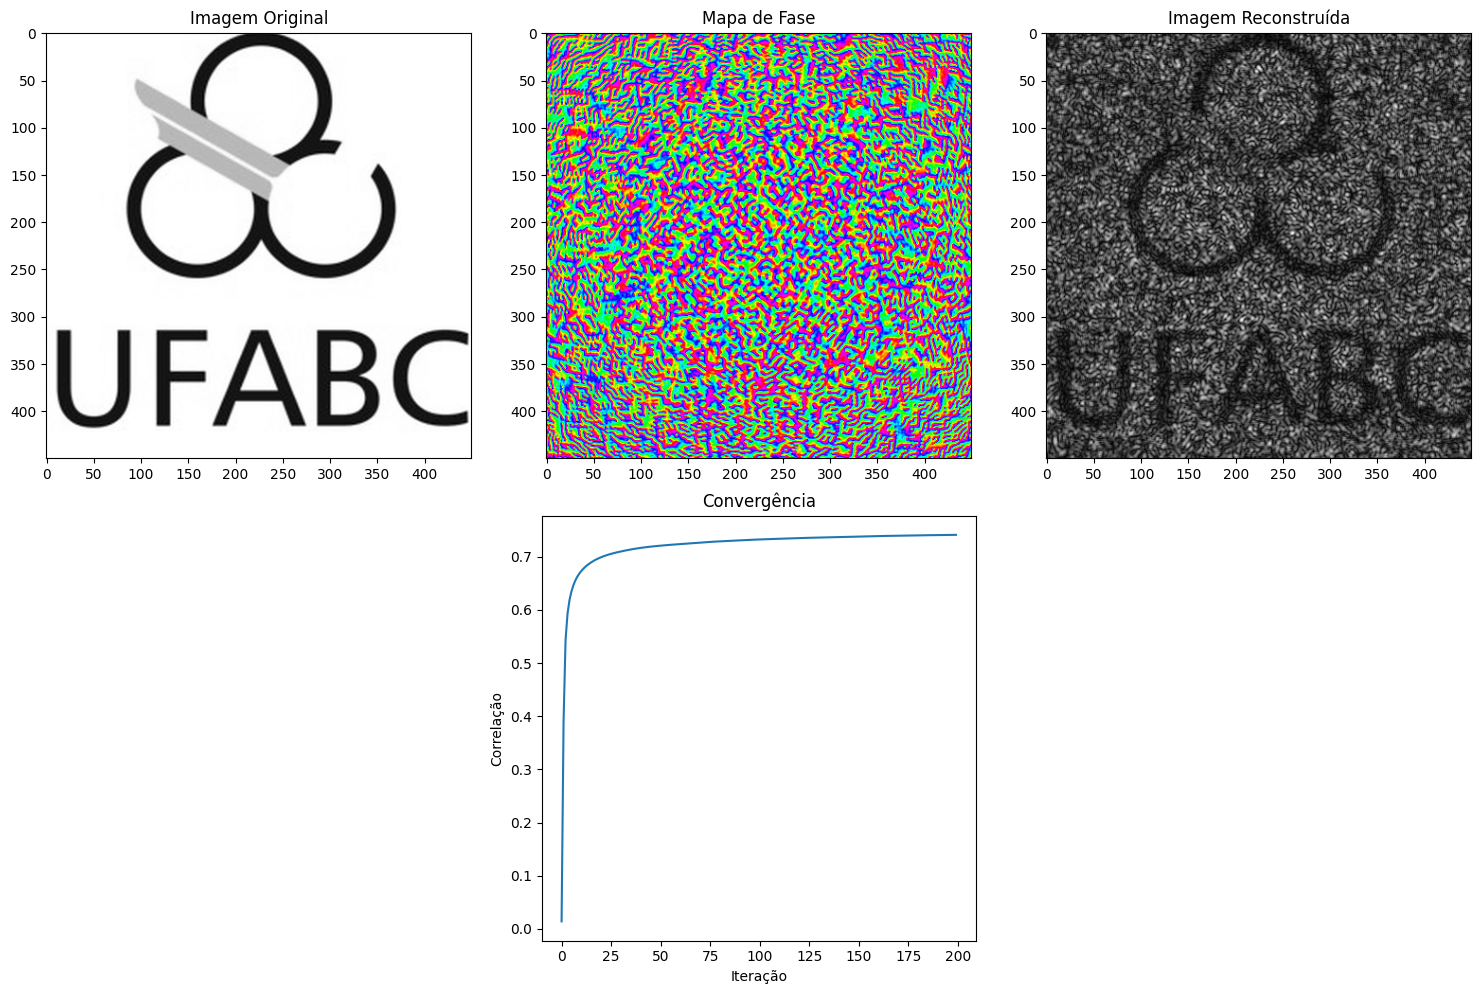

In [ ]:
wavelength = 1064e-9  # 1064 nm
z = 380e-6           # 380 μm
dx = 520e-9          # pixel pitch
NA = 0.65            # abertura numérica
num_iter = 200       # número de iterações

print("Carregando e pré-processando imagem...")
target_original = load_and_preprocess_image('/content/WhatsApp Image 2025-11-06 at 16.18.47.png', target_size=(450, 450))

print("Executando algoritmo de Gerchberg-Saxton...")

img_original, img_reconstruida, mapa_de_fase, correlations = gerchberg_saxton_angular_spectrum(
    target_original,
    wavelength,
    z,
    dx,
    NA,
    num_iter
)
print(f"\nCorrelação final: {correlations[-1]:.4f}")

print(f"Dimensões da Imagem Original: {img_original.shape}")
print(f"Dimensões da Imagem Reconstruída: {img_reconstruida.shape}")
print(f"Dimensões do Mapa de Fase: {mapa_de_fase.shape}")

# np.savetxt('phase_map_x_polarization.txt', mapa_de_fase)
# np.savetxt('correlations.txt', correlations)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 3, 2)
plt.imshow(mapa_de_fase, cmap='hsv')
plt.title('Mapa de Fase')

plt.subplot(2, 3, 3)
plt.imshow(img_reconstruida, cmap='gray')
plt.title('Imagem Reconstruída')

plt.subplot(2, 3, 5)
plt.plot(correlations)
plt.title('Convergência')
plt.xlabel('Iteração')
plt.ylabel('Correlação')

plt.tight_layout()
plt.show()

## Polarização y:

In [ ]:
def generate_dammann_phase_map(
    P: float = 520e-9,
    wavelength: float = 1064e-9,
    supercell_pixels: int = 45,
    n_supercells: int = 10,
    iters_gs: int = 400,
    random_seed: int = 0,
    verbose: bool = True
) -> tuple[np.ndarray, dict, list]:
    """
    Gera o mapa de fase para uma grade de Dammann (spot-cloud) usando o algoritmo GS.
    """
    np.random.seed(random_seed)

    N_super = supercell_pixels
    dx = P
    d = dx * N_super

    # --- Grade k e alvo ---
    # (Esta função usa np.fft, o que não conflita com o Bloco 1)
    kx = np.fft.fftfreq(N_super, d=dx)
    ky = np.fft.fftfreq(N_super, d=dx)
    kx_shift = np.fft.fftshift(kx)
    ky_shift = np.fft.fftshift(ky)
    KX, KY = np.meshgrid(kx_shift, ky_shift)
    K_rad = np.sqrt(KX**2 + KY**2)
    target_radius = min(1.0 / wavelength, 1.0 / (2.0 * dx))
    target_amp = (K_rad <= target_radius).astype(float)

    # --- Algoritmo GS ---
    plane_field = np.exp(1j * 2.0 * np.pi * np.random.rand(N_super, N_super))
    errors = []

    # Loop de iteração para Dammann
    gs_iterator = range(iters_gs)
    if verbose:
        # Cria uma barra de progresso se 'verbose' for True
        gs_iterator = tqdm(range(iters_gs), desc="  Iterações GS (Y)", leave=False)

    for it in gs_iterator:
        far = np.fft.fft2(plane_field)
        far_shift = np.fft.fftshift(far)

        amp_current = np.abs(far_shift)
        err = np.sqrt(np.mean((amp_current / (amp_current.max() + 1e-9) - target_amp)**2))
        errors.append(err)

        far_shift = target_amp * np.exp(1j * np.angle(far_shift))
        far = np.fft.ifftshift(far_shift)

        plane_field = np.fft.ifft2(far)
        plane_field = np.exp(1j * np.angle(plane_field))

    supercell_phase = np.angle(plane_field)

    # --- Construção da Metassuperfície Completa ---
    full_phase = np.tile(supercell_phase, (n_supercells, n_supercells))

    if verbose:
        print(f"  Mapa Dammann (Y) gerado: {full_phase.shape} pixels")

    metrics = {} # Vazio, focado apenas na geração de fase

    return full_phase, metrics, errors


Iniciando Geração de Fase...


  Mapa Dammann (Y) gerado: (450, 450) pixels
Geração de Fase Concluída.
Iniciando análise e plotagem...
Plot 1: Gerando plot_mapa_fase.png...
Plot 2: Gerando plot_erro_gs.png...
Análise: Calculando Far-Field da metassuperfície completa...
Análise: Extraindo ordens de difração...
Análise concluída. Encontradas 1513 ordens propagantes.
Plot 3: Gerando plot_far_field.png...
Plot 4: Gerando plot_ordens_scatter.png...

Todos os plots foram salvos como arquivos .png.

--- Resumo das Ordens ---
    p  q     intensity            k_p            k_q
0 -21 -6  3.025955e+07 -897435.897436 -256410.256410
1 -21 -5  2.756224e+07 -897435.897436 -213675.213675
2 -21 -4  2.966075e+07 -897435.897436 -170940.170940
3 -21 -3  2.624582e+07 -897435.897436 -128205.128205
4 -21 -2  2.435471e+07 -897435.897436  -85470.085470


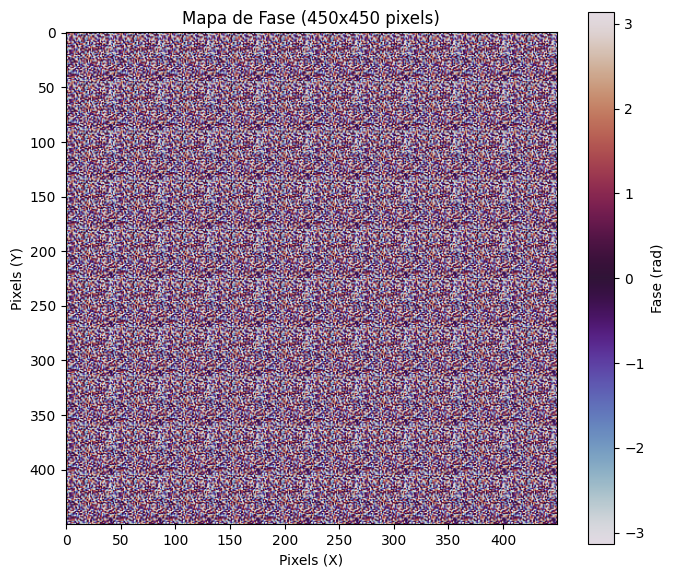

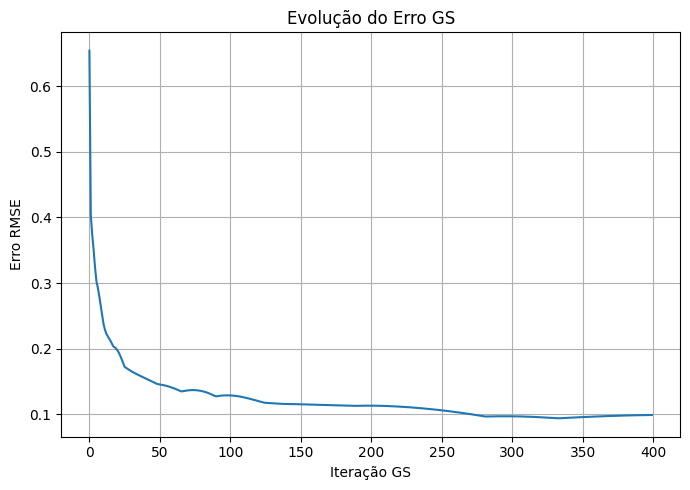

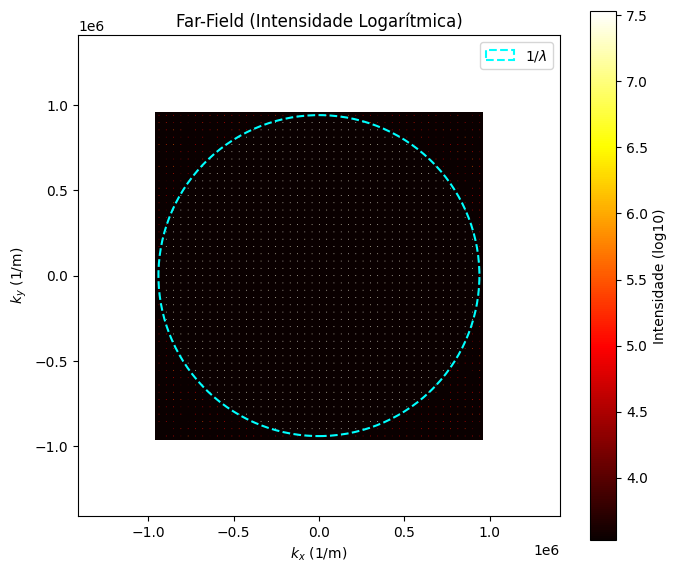

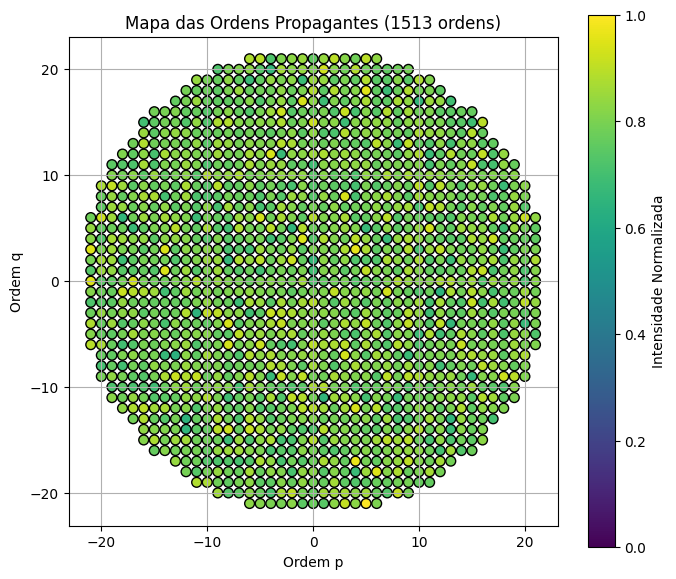

In [ ]:
def analyze_and_plot_results(
    full_phase: np.ndarray,
    errors: list,
    P: float,
    wavelength: float,
    supercell_pixels: int
) -> pd.DataFrame:
    """
    Analisa e plota os resultados da metassuperfície.
    Retorna um DataFrame com os dados das ordens propagantes.
    """

    print("Iniciando análise e plotagem...")

    # --- Plot 1: Mapa de Fase ---
    print("Plot 1: Gerando plot_mapa_fase.png...")
    plt.figure(figsize=(7, 6))
    plt.imshow(full_phase, cmap='twilight', extent=None)
    plt.colorbar(label="Fase (rad)")
    plt.title(f"Mapa de Fase ({full_phase.shape[0]}x{full_phase.shape[1]} pixels)")
    plt.xlabel("Pixels (X)")
    plt.ylabel("Pixels (Y)")
    plt.tight_layout()
    plt.savefig("plot_mapa_fase.png", dpi=150)

    # --- Plot 2: Evolução do Erro ---
    print("Plot 2: Gerando plot_erro_gs.png...")
    plt.figure(figsize=(7, 5))
    plt.plot(errors)
    plt.xlabel("Iteração GS")
    plt.ylabel("Erro RMSE")
    plt.title("Evolução do Erro GS")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plot_erro_gs.png", dpi=150)

    # --- Análise de Far-Field (Células 8 & 9) ---
    print("Análise: Calculando Far-Field da metassuperfície completa...")
    N_full = full_phase.shape[0]
    dx_full = P

    # Criar a grade k
    kx_full = np.fft.fftfreq(N_full, d=dx_full)
    ky_full = np.fft.fftfreq(N_full, d=dx_full)
    kx_full_shift = np.fft.fftshift(kx_full)
    ky_full_shift = np.fft.fftshift(ky_full)

    # Calcular o far-field
    plane_field_full = np.exp(1j * full_phase)
    far_field_full = np.fft.fft2(plane_field_full)
    far_field_full_shift = np.fft.fftshift(far_field_full)
    far_field_intensity = np.abs(far_field_full_shift)**2

    print("Análise: Extraindo ordens de difração...")
    d_supercell = supercell_pixels * P
    max_order = int(np.floor((d_supercell) / wavelength))

    p_range = np.arange(-max_order, max_order + 1)
    q_range = np.arange(-max_order, max_order + 1)
    order_data = []

    for p in p_range:
        for q in q_range:
            k_p = p / d_supercell
            k_q = q / d_supercell

            idx_p = np.argmin(np.abs(kx_full_shift - k_p))
            idx_q = np.argmin(np.abs(ky_full_shift - k_q))

            k_rad_order = np.sqrt(k_p**2 + k_q**2)
            if k_rad_order <= (1.0 / wavelength):
                intensity = far_field_intensity[idx_q, idx_p]
                order_data.append({'p': p, 'q': q, 'intensity': intensity, 'k_p': k_p, 'k_q': k_q})

    df_orders = pd.DataFrame(order_data)
    print(f"Análise concluída. Encontradas {len(df_orders)} ordens propagantes.")

    print("Plot 3: Gerando plot_far_field.png...")
    log_intensity = np.log10(far_field_intensity + 1e-9)
    vmax_val = log_intensity.max()
    vmin_val = vmax_val - 4

    plt.figure(figsize=(7, 6))
    plt.imshow(
        log_intensity,
        cmap='hot',
        extent=[kx_full_shift.min(), kx_full_shift.max(), ky_full_shift.min(), ky_full_shift.max()],
        vmin=vmin_val,
        vmax=vmax_val,
        origin='lower'
    )

    k_max_plot = 1.0 / wavelength
    circle = plt.Circle((0, 0), k_max_plot, color='cyan', fill=False, linestyle='--', linewidth=1.5, label=r'$1/\lambda$')
    plt.gca().add_artist(circle)
    plt.legend(handles=[circle])

    plt.xlim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.ylim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.colorbar(label="Intensidade (log10)")
    plt.title("Far-Field (Intensidade Logarítmica)")
    plt.xlabel(r"$k_x$ (1/m)")
    plt.ylabel(r"$k_y$ (1/m)")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.savefig("plot_far_field.png", dpi=150)

    print("Plot 4: Gerando plot_ordens_scatter.png...")
    if not df_orders.empty:
        plt.figure(figsize=(7, 6))
        norm_intensity = df_orders['intensity'] / (df_orders['intensity'].max() + 1e-9)

        sc = plt.scatter(df_orders['p'], df_orders['q'], c=norm_intensity, cmap='viridis', s=50, edgecolor="k", vmin=0)
        plt.colorbar(sc, label="Intensidade Normalizada")
        plt.xlabel("Ordem p")
        plt.ylabel("Ordem q")
        plt.title(f"Mapa das Ordens Propagantes ({len(df_orders)} ordens)")
        plt.grid(True)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        plt.savefig("plot_ordens_scatter.png", dpi=150)
    else:
        print("Plot 4: DataFrame de ordens vazio, pulando o scatter plot.")

    print("\nTodos os plots foram salvos como arquivos .png.")

    return df_orders

P = 520e-9
wavelength = 1064e-9
supercell_pixels = 45
n_supercells = 10
iters_gs = 400
random_seed = 0

print("Iniciando Geração de Fase...")
full_phase, _, errors = generate_dammann_phase_map(
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels,
    n_supercells=n_supercells,
    iters_gs=iters_gs,
    random_seed=random_seed,
    verbose=True
)
print("Geração de Fase Concluída.")

df_ordens_propagantes = analyze_and_plot_results(
    full_phase=full_phase,
    errors=errors,
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels
)

print("\n--- Resumo das Ordens ---")
print(df_ordens_propagantes.head())

# Carregamento dos Modelos Treinados

In [ ]:
IMG_SIZE = 64
LATENT_DIM = 128 # Dimensão do vetor latente

GENERATOR_PATH = "/content/generator_teste_5_final.pth"
SIMULATOR_PATH = "/content/simulador_NG_teste_1.pth"

# --- Componentes Globais ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar Gerador
try:
    generator = CPPN_Generator(latent_dim=LATENT_DIM, in_coords=2).to(device)
    generator.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator.eval()
    print(f"Gerador '{GENERATOR_PATH}' carregado em {device}.")
except Exception as e:
    print(f"Erro ao carregar Gerador: {e}")
    exit()

# Carregar Simulador
try:
    # Use a arquitetura ResNet que você definiu (ex: ResNet-18)
    simulator = ResNetSimulator(in_channels=1, n_outputs=4).to(device)
    simulator.load_state_dict(torch.load(SIMULATOR_PATH, map_location=device))
    simulator.eval()
    print(f"Simulador '{SIMULATOR_PATH}' carregado em {device}.")
except Exception as e:
    print(f"Erro ao carregar Simulador: {e}")
    exit()

# Criar a grade de coordenadas (apenas uma vez)
def make_coordinate_grid(size, dev):
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(xs, ys)
    coords = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype(np.float32)
    return torch.from_numpy(coords).to(dev)

coords_grid = make_coordinate_grid(IMG_SIZE, device)
print("Grade de coordenadas criada.")

Gerador '/content/generator_teste_5_final.pth' carregado em cuda.
Simulador '/content/simulador_NG_teste_1.pth' carregado em cuda.
Grade de coordenadas criada.


# FITNESS FUNCTION

In [ ]:
def evaluate_meta_atom(individual, target_phase_x, target_phase_y):
    """
    Função de Custo para o GA.
    Baseada na fórmula: min{ |E_hat_xx - E_target_xx| + |E_hat_yy - E_target_yy| }
    onde E_target = 1.0 * e^(i*phi_target)

    'individual' é o vetor latente 'z'.
    """
    global generator, simulator, device, coords_grid

    # 1. Converter "gene" (lista) para tensor
    z = torch.tensor([individual], dtype=torch.float32).to(device)

    with torch.no_grad():
        # 2. Gerador: z -> img
        img = generator(coords_grid, z)
        img_binary = (img > 0.5).float()

        # 3. Simulador: img -> [Re/Im]
        # Saída: [S24_r, S24_i, S13_r, S13_i]
        outputs_raw = simulator(img_binary)

        s24_r = outputs_raw[0, 0].item()
        s24_i = outputs_raw[0, 1].item()
        s13_r = outputs_raw[0, 2].item()
        s13_i = outputs_raw[0, 3].item()

    # 4. Obter a saída complexa prevista
    # Pol X (TE / S13) -> E_hat_xx no seu artigo
    e_hat_x = s13_r + 1j * s13_i

    # Pol Y (TM / S24) -> E_hat_yy no seu artigo
    e_hat_y = s24_r + 1j * s24_i

    # 5. Criar os alvos complexos ideais (Amplitude 1, Fase desejada)
    # e^(i*phi_xx)
    e_target_x = 1.0 * (np.cos(target_phase_x) + 1j * np.sin(target_phase_x))

    # e^(i*phi_yy)
    e_target_y = 1.0 * (np.cos(target_phase_y) + 1j * np.sin(target_phase_y))

    # 6. Calcular a Função de Custo (Distância no plano complexo)
    cost_x = np.abs(e_hat_x - e_target_x)
    cost_y = np.abs(e_hat_y - e_target_y)

    total_cost = cost_x + cost_y

    # DEAP requer que a função retorne uma tupla
    return (total_cost,)

# Algoritmo Genético

In [ ]:
# MINIMIZAR o custo (-1.0)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Gene: um float aleatório entre -1 e 1 (range comum para vetores latentes)
toolbox.register("attr_float", random.uniform, -1, 1)

# Indivíduo: um vetor de LATENT_DIM (128) genes
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=LATENT_DIM)

# População: uma lista de indivíduos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operadores genéticos
toolbox.register("mate", tools.cxBlend, alpha=0.5) # Cruzamento
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1) # Mutação
toolbox.register("select", tools.selTournament, tournsize=3) # Seleção

Loop principal:

In [ ]:
# Carregar os mapas de fase alvo
phase_map_x = mapa_de_fase
phase_map_y = full_phase
rows, cols = phase_map_x.shape

# Armazenar os melhores vetores latentes encontrados
best_latent_vectors = np.empty((rows, cols), dtype=object)

# Parâmetros do GA
POP_SIZE = 1   # Tamanho da população
NGEN = 1       # Número de gerações
CXPB = 0.7      # Probabilidade de crossover
MUTPB = 0.2     # Probabilidade de mutação

print(f"\n--- INICIANDO OTIMIZAÇÃO GA ({rows}x{cols} META-ÁTOMOS) ---")
print(f"População por átomo: {POP_SIZE}, Gerações por átomo: {NGEN}\n")

# Loop "Round-Robin" por cada meta-átomo
for i in range(rows):
    for j in range(cols):
        print(f"--- Otimizando meta-átomo [{i}, {j}] ---")

        # Obter os alvos de fase para este pixel
        target_px = phase_map_x[i, j]
        target_py = phase_map_y[i, j]

        # Registrar a função de fitness específica para ESTE pixel [i, j]
        # Isso "injeta" os alvos na função de avaliação
        toolbox.register("evaluate", evaluate_meta_atom,
                         target_phase_x=target_px,
                         target_phase_y=target_py)

        # Criar a população inicial para este átomo
        pop = toolbox.population(n=POP_SIZE)

        # Estatísticas (opcional, mas útil)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("max", np.max)

        # Rodar o algoritmo evolucionário (GA)
        # O 'eaSimple' é um GA canônico
        pop, logbook = algorithms.eaSimple(pop, toolbox,
                                           cxpb=CXPB,
                                           mutpb=MUTPB,
                                           ngen=NGEN,
                                           stats=stats,
                                           verbose=True)

        # Salvar o melhor indivíduo (vetor latente) encontrado
        best_ind = tools.selBest(pop, 1)[0]
        best_latent_vectors[i, j] = np.array(best_ind)

        print(f"Melhor fitness para [{i}, {j}]: {best_ind.fitness.values[0]:.4f}")
        print("-" * 30)

print("\n--- OTIMIZAÇÃO CONCLUÍDA ---")
np.save("metasurface_latent_vectors.npy", best_latent_vectors)
print("Array de vetores latentes (10, 10, 128) salvo em 'metasurface_latent_vectors.npy'")

A saída de streaming foi truncada nas últimas 5000 linhas.
gen	nevals	avg    	max    
0  	1     	3.72486	3.72486
1  	0     	3.72486	3.72486
Melhor fitness para [448, 67]: 3.7249
------------------------------
--- Otimizando meta-átomo [448, 68] ---
gen	nevals	avg    	max    
0  	1     	3.81484	3.81484
1  	1     	3.84889	3.84889
Melhor fitness para [448, 68]: 3.8489
------------------------------
--- Otimizando meta-átomo [448, 69] ---
gen	nevals	avg     	max     
0  	1     	0.820267	0.820267
1  	0     	0.820267	0.820267
Melhor fitness para [448, 69]: 0.8203
------------------------------
--- Otimizando meta-átomo [448, 70] ---
gen	nevals	avg    	max    
0  	1     	3.16618	3.16618
1  	0     	3.16618	3.16618
Melhor fitness para [448, 70]: 3.1662
------------------------------
--- Otimizando meta-átomo [448, 71] ---
gen	nevals	avg    	max    
0  	1     	1.26906	1.26906
1  	0     	1.26906	1.26906
Melhor fitness para [448, 71]: 1.2691
------------------------------
--- Otimizando meta-átomo

# Verificação de Performance

In [ ]:
print("\nVerificando performance final da metassuperfície otimizada...")

final_phase_x = np.zeros((rows, cols))
final_phase_y = np.zeros((rows, cols))
final_amp_x = np.zeros((rows, cols))
final_amp_y = np.zeros((rows, cols))

for i in range(rows):
    for j in range(cols):

        z_vector = best_latent_vectors[i, j]

        z = torch.from_numpy(z_vector).float().unsqueeze(0).to(device)
        with torch.no_grad():
            img = generator(coords_grid, z)
            img_binary = (img > 0.5).float()
            outputs_raw = simulator(img_binary)

            s_tm = outputs_raw[0, 0].item() + 1j * outputs_raw[0, 1].item()
            s_te = outputs_raw[0, 2].item() + 1j * outputs_raw[0, 3].item()

        final_phase_x[i, j] = np.angle(s_te)
        final_amp_x[i, j] = np.abs(s_te)
        final_phase_y[i, j] = np.angle(s_tm)
        final_amp_y[i, j] = np.abs(s_tm)

# --- Plotar resultados ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.suptitle("Resultados Finais da Otimização", fontsize=16)

# Coluna 1: Alvos
im0 = axes[0, 0].imshow(phase_map_x, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 0].set_title("Alvo - Fase X (rad)")
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[1, 0].imshow(phase_map_y, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title("Alvo - Fase Y (rad)")
fig.colorbar(im1, ax=axes[1, 0])

# Coluna 2: Fases Obtidas
im2 = axes[0, 1].imshow(final_phase_x, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 1].set_title("Obtido - Fase X (rad)")
fig.colorbar(im2, ax=axes[0, 1])

im3 = axes[1, 1].imshow(final_phase_y, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[1, 1].set_title("Obtido - Fase Y (rad)")
fig.colorbar(im3, ax=axes[1, 1])

# Coluna 3: Amplitudes Obtidas
im4 = axes[0, 2].imshow(final_amp_x, cmap='viridis', vmin=0, vmax=1)
axes[0, 2].set_title("Obtido - Amplitude X (Eficiência)")
fig.colorbar(im4, ax=axes[0, 2])

im5 = axes[1, 2].imshow(final_amp_y, cmap='viridis', vmin=0, vmax=1)
axes[1, 2].set_title("Obtido - Amplitude Y (Eficiência)")
fig.colorbar(im5, ax=axes[1, 2])

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.